# Discovering Binding Sites on a Viral Genome with SMEAGOL

This notebook demonstrates the functions for binding site discovery and enrichment. Here we use the genome of the Lymphocytic choriomeningitis mammarenavirus as an example.

## Import requirements

In [1]:
# General imports
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Find SMEAGOL
import sys
sys.path.append('../../SMEAGOL')

# Custom imports
from smeagol.enrich import *
from smeagol.visualize import *
from smeagol.models import PWMModel 
from smeagol.encode import MultiSeqEncoding
from smeagol.io import *
from smeagol.scan import find_sites_multiseq

Using TensorFlow backend.


## Load and explore PWMs filtered from Attract DB

Below, we provide the path to the file containing PWMs filtered from Attract DB and RBPDB.

In [2]:
pwm_file = '../VirusHostInteractionAtlas/DATA/PWMs/attract_rbpdb_filtered_human_pwms.h5'

We read PWMs from this file:

In [3]:
%%time
pwms = pd.read_hdf(pwm_file, key="data")
pwms.head()

CPU times: user 115 ms, sys: 19.7 ms, total: 134 ms
Wall time: 240 ms


,Matrix_id,Gene_name,Gene_id,probs,weight
0,s36,HNRNPDL,ENSG00000152795,"[[0.844325153374, 0.000766871165644, 0.1541411...","[[1.7558705993328931, -8.3487281542314, -0.697..."
1,M269_0.6,ZFP36,ENSG00000128016,"[[0.97, 0.01, 0.01, 0.01], [0.97, 0.01, 0.01, ...","[[1.956056652412403, -4.643856189774724, -4.64..."
2,M157_0.6,CELF5,ENSG00000161082,"[[0.0839638134106, 0.0839638134106, 0.08396381...","[[-1.5740884983277694, -1.5740884983277694, -1..."
3,M042_0.6,PABPC4,ENSG00000090621,"[[0.778437101049, 0.103079871719, 0.1105254833...","[[1.6386523770814128, -1.278165447983456, -1.1..."
4,M062_0.6,SART3,ENSG00000075856,"[[0.757020210373, 0.0809932638995, 0.080993263...","[[1.5984037218569163, -1.6260542637885405, -1...."


The `pwms` dataframe contains all the PWMs filtered from Attract and RBPDB. The column `Matrix_id` gives a unique ID for each PWM, and the column `Gene_name` gives the name of the RBP. We can see how many PWMs are in our list:

In [4]:
len(pwms)

233

We have multiple PWMs for some RBPs. To see how many distinct RBPs are in the list:

In [5]:
len(pd.unique(pwms.Gene_name))

106

We can select a particular PWM using its `Matrix_id`:

In [6]:
pwms[pwms.Matrix_id=='s36']

,Matrix_id,Gene_name,Gene_id,probs,weight
0,s36,HNRNPDL,ENSG00000152795,"[[0.844325153374, 0.000766871165644, 0.1541411...","[[1.7558705993328931, -8.3487281542314, -0.697..."


We can also select all PWMs for an RBP:

In [7]:
pwms[pwms.Gene_name=='HNRNPDL']

,Matrix_id,Gene_name,Gene_id,probs,weight
0,s36,HNRNPDL,ENSG00000152795,"[[0.844325153374, 0.000766871165644, 0.1541411...","[[1.7558705993328931, -8.3487281542314, -0.697..."
89,s44,HNRNPDL,ENSG00000152795,"[[0.597222222222, 0.00198412698413, 0.39880952...","[[1.2563397532592488, -6.977279923497724, 0.67..."
158,s35,HNRNPDL,ENSG00000152795,"[[0.495098039216, 0.00490196078431, 0.00490196...","[[0.9857861407812133, -5.672425341972592, -5.6..."
179,s43,HNRNPDL,ENSG00000152795,"[[0.25, 0.0838870431894, 0.665282392027, 0.000...","[[0.0, -1.57540819400737, 1.412038755649923, -..."


We can plot any PWM in `pwms` as follows:

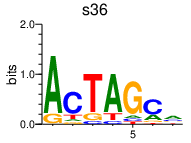

In [8]:
plot_pwm(pwms, Matrix_id='s36')

Finally, we encode all these PWMs as a convolutional model. This will allow us to scan genome sequence(s).

In [9]:
model = PWMModel(pwms)

## Load the genome

Below we provide the path to the fasta file containing the genome sequence to be analyzed.

In [10]:
#genome_file = '../VirusHostInteractionAtlas/DATA/Genomes/Genomes/IV/Monopartite/Coronaviridae/GCF_009858895.2/GCF_009858895.2_ASM985889v3_genomic.fna.gz'
genome_file = '../VirusHostInteractionAtlas/DATA/Genomes/Genomes/V/Segmented/Orthomyxoviridae/GCF_000820495.2/GCF_000820495.2_ViralMultiSegProj14656_genomic.fna.gz'

We need to specify whether this is a `+` or `-` sense viral genome.

In [11]:
genome_sense = '+'

We now read the genome sequence, and store it an object called `genome`:

In [12]:
%%time
genome = read_fasta(genome_file)
genome

Read 8 records from ../VirusHostInteractionAtlas/DATA/Genomes/Genomes/V/Segmented/Orthomyxoviridae/GCF_000820495.2/GCF_000820495.2_ViralMultiSegProj14656_genomic.fna.gz
CPU times: user 13.9 ms, sys: 6.91 ms, total: 20.8 ms
Wall time: 57.9 ms


[SeqRecord(seq=Seq('AGCAGAAGCGGAGCTTTAAGATGAATATAAATCCATATTTTCTTTTCATAGATG...ACT'), id='NC_002204.1', name='NC_002204.1', description='NC_002204.1 Influenza B virus RNA 1, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGACGTTGGCTAAAATTGAACTACTAAAGCAGCTGTTAAGGGACAATGAAGCC...TAA'), id='NC_002205.1', name='NC_002205.1', description='NC_002205.1 Influenza B virus (B/Lee/1940) segment 2, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATACTTTTATTACAAAGAATTTCCAGACTACAATAATACAAAAGGCCAAA...TTT'), id='NC_002206.1', name='NC_002206.1', description='NC_002206.1 Influenza B virus (B/Lee/1940) segment 3, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('AGCAGAAGCGTTGCATTTTCTAATATCCACAAAATGAAGGCAATAATTGTACTA...ACT'), id='NC_002207.1', name='NC_002207.1', description='NC_002207.1 Influenza B virus (B/Lee/1940) segment 4, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('GGCAGAAGCACAGCATTTTCTTGTGAGCTTCGAGCACTAATAAAACTGAAAATC...ACT'), id='NC_002208.1', name='NC_002208.1', descrip

In [13]:
genome_len = sum([len(x) for x in genome])
genome_len

14452

## Number of binding sites found at various thresholds

We generate a background distribution by shuffling the genome sequence multiple times. We need to specify two parameters:

In [14]:
simN=300 # Number of times to shuffle
simK=2 # k-mer length to keep fixed

We begin by demonstrating how to get the distribution of number of binding sites by score. We begin by selecting a preliminary, low threshold of 0.4. 
In the process, we can also choose whether to encode and scan the reverse complement sequence. To encode and scan the reverse complement sequence as well as the given sequence, we specify `rcomp=True`.

In [15]:
rcomp=False

We will now scan the real genome and the shuffled genome sequences for binding sites, and count the number of sites based on their score. This can take a long time!

In [16]:
threshold_binned_results = examine_thresholds(genome, model, simN, simK, rcomp, sense=genome_sense, 
                                              min_threshold=0.4, verbose=True, combine_seqs=True)

Shuffled 8 input sequence(s) 300 times while conserving k-mer frequency for k = 2



We can view the first few shuffled sequences:

In [17]:
threshold_binned_results['shuf_seqs'][:3]

[SeqRecord(seq=Seq('AGATCAACTTGCCGTTGGAAAGAATGTGACTGCACAAAGCCCCTCAAAAACAGC...CCT'), id='background_seq_1', name='NC_002204.1', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('AGAGGCAGATTCTAGATGTAGAATAAGCCACACAAATGGGACAAAAAAATAAAA...CTT'), id='background_seq_2', name='NC_002204.1', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('AGGCAATACACCATCAAGCGGGTATGAAGCCATAAAGTTTGGCAGGCCACATCA...ACT'), id='background_seq_3', name='NC_002204.1', description='<unknown description>', dbxrefs=[])]

`real_binned` now contains the number of binding sites found for each PWM, binned by score. We can view the first few entries:

In [18]:
threshold_binned_results['real_binned'].head()

,Matrix_id,sense,bin,num
0,1053,+,0.4,20
1,1053,+,0.5,0
2,1053,+,0.6,12
3,1053,+,0.7,29
4,1053,+,0.8,0


The `num` column records the number of binding sites per PWM, per bin.

We plot the distribution of binding sites on the real genome for a given PWM. Here, we are plotting the distribution of binding sites only on the `+` sense strand.

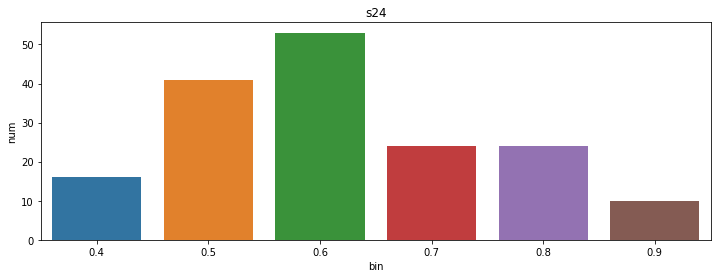

In [19]:
plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='s24', sense ='+')

`shuf_binned` contains the number of binding sites per bin, in the shuffled genomes.

In [20]:
threshold_binned_results['shuf_binned'].head()

,Matrix_id,sense,bin,id,num
0,1053,+,0.4,background_seq_1,23
1,1053,+,0.4,background_seq_10,25
2,1053,+,0.4,background_seq_100,27
3,1053,+,0.4,background_seq_101,25
4,1053,+,0.4,background_seq_102,25


We can now plot the distribution of binding sites per bin for the real and shuffled genome sequences, for any given PWM.

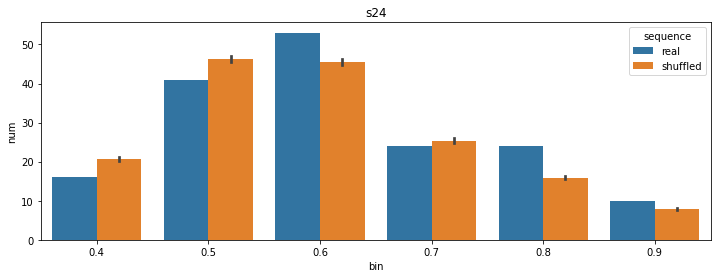

In [21]:
plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='s24', sense ='+', 
                       shuf_preds=threshold_binned_results['shuf_binned'])

### Binding site discovery and enrichment for a specified threshold

Based on this exploration, we can select a higher threshold to identify binding sites, and test for enrichment of PWM matching sites in the genome using a simple function.

In [22]:
simN=300
simK=2
rcomp=True
threshold=0.8

In [23]:
%%time
enrichment_result = enrich_in_genome(genome, model, simN=simN, simK=simK, rcomp=rcomp, sense=genome_sense, 
                                     threshold=threshold, verbose=True, combine_seqs=True, background='binomial')

Shuffled 8 input sequence(s) 300 times while conserving k-mer frequency for k = 2
CPU times: user 37 s, sys: 13 s, total: 50.1 s
Wall time: 49.5 s


In [24]:
enrichment_result.keys()

dict_keys(['enrichment', 'real_sites', 'real_counts', 'shuf_stats', 'shuf_counts', 'shuf_seqs'])

We can view the locations of the binding sites:

In [25]:
real_sites = enrichment_result['real_sites']
real_sites.head()

,id,name,sense,start,Matrix_id,width,end,score,max_score,frac_score
0,NC_002204.1,NC_002204.1,+,7,s42,5,12,5.967936,6.744486,0.884862
1,NC_002204.1,NC_002204.1,+,13,s9,5,18,7.148956,7.148956,1.000000
2,NC_002204.1,NC_002204.1,+,13,s1,5,18,6.947326,7.529893,0.922633
3,NC_002204.1,NC_002204.1,+,13,s6,5,18,6.947325,7.529893,0.922633
4,NC_002204.1,NC_002204.1,+,23,75,6,29,5.997296,5.997296,1.000000


And the number of binding sites per PWM in the real genome:

In [26]:
real_counts = enrichment_result['real_counts']
real_counts.head()

,Matrix_id,sense,num
0,1053,+,23
1,1053,-,21
2,1169,+,253
3,1169,-,81
4,1170,+,127


We can plot the distribution of number of binding sites per PWM, per strand:

<AxesSubplot:xlabel='num', ylabel='Count'>

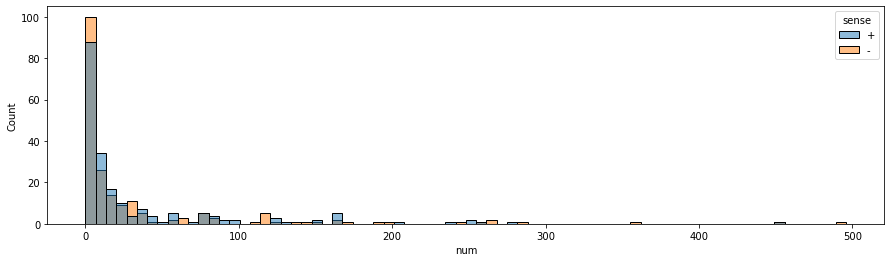

In [27]:
plt.figure(figsize=(15, 4))
sns.histplot(data=real_counts, x='num', hue='sense', bins='auto')

We can see the number of binding sites found on the shuffled genomes:

In [28]:
shuf_counts = enrichment_result['shuf_counts']
shuf_counts.head()

,Matrix_id,sense,id,num
0,1053,+,background_seq_1,16
1,1053,+,background_seq_10,26
2,1053,+,background_seq_100,26
3,1053,+,background_seq_101,24
4,1053,+,background_seq_102,13


In [29]:
shuf_stats = enrichment_result['shuf_stats']
shuf_stats.head()

,Matrix_id,sense,len,avg,sd
0,1053,+,300,21.546667,4.579417
1,1053,-,300,24.220000,4.721501
2,1169,+,300,231.726667,13.216437
3,1169,-,300,69.276667,8.120340
4,1170,+,300,126.756667,7.836805


We can examine the enrichment for each PWM.

In [30]:
enr = enrichment_result['enrichment']
enr.head()

,Matrix_id,sense,num,len,avg,sd,p,fdr
0,M042_0.6,+,4,300,26.360000,6.887806,1.506155e-07,0.000030
1,75,+,451,300,541.633333,32.098702,5.049959e-05,0.005100
2,s26,+,280,300,220.750000,15.011729,1.084125e-04,0.007300
3,s12,+,42,300,23.136667,4.779904,3.525793e-04,0.017805
4,M227_0.6,+,12,300,4.786667,2.253460,3.900234e-03,0.157569


We can separate out the PWMs that are enriched / depleted on each strand:

In [31]:
enr_pos = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='+')].reset_index(drop=True) # enriched on + strand
enr_neg = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='-')].reset_index(drop=True) # enriched on - strand
dep_pos = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='+')].reset_index(drop=True) # depleted on + strand
dep_neg = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='-')].reset_index(drop=True) # depleted on - strand

print(len(enr_pos))
print(len(enr_neg))
print(len(dep_pos))
print(len(dep_neg))

2
1
2
7


We can view the PWMs that are enriched on the `+` strand:

In [32]:
enr_pos

,Matrix_id,sense,num,len,avg,sd,p,fdr
0,s26,+,280,300,220.750000,15.011729,0.000108,0.007300
1,s12,+,42,300,23.136667,4.779904,0.000353,0.017805


And match these to RBPs:

In [33]:
enr_pos = enr_pos.merge(pwms.loc[:,['Matrix_id', 'Gene_name']])
enr_pos.head()

,Matrix_id,sense,num,len,avg,sd,p,fdr,Gene_name
0,s26,+,280,300,220.750000,15.011729,0.000108,0.007300,SFPQ
1,s12,+,42,300,23.136667,4.779904,0.000353,0.017805,PTBP1


We can plot the number of binding sites for any PWM in windows across the genome:

In [34]:
r = count_in_sliding_windows(real_sites[real_sites.sense=='+'], genome, 's26', 100)
r.head()

,id,start,end,count
0,NC_002204.1,0,100,0
1,NC_002204.1,100,200,2
2,NC_002204.1,200,300,0
3,NC_002204.1,300,400,1
4,NC_002204.1,400,500,0


And visualize it:

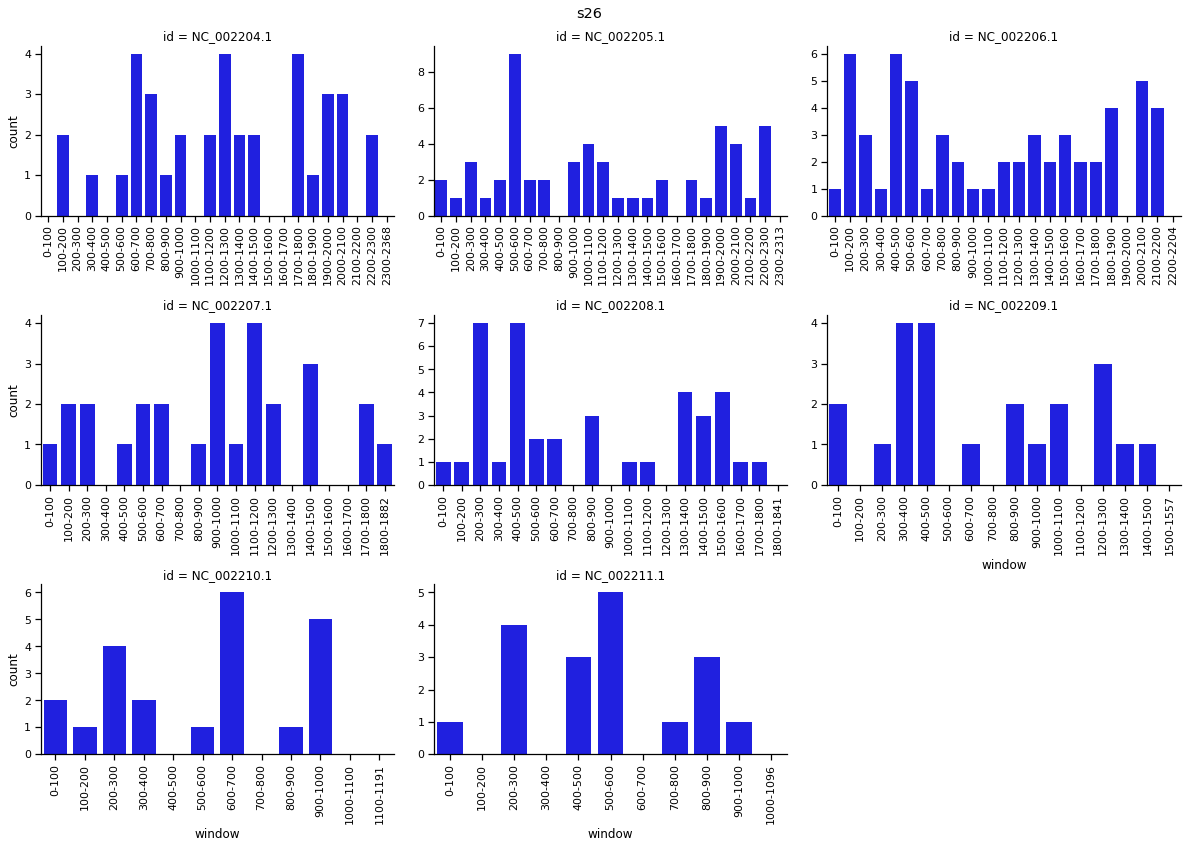

In [35]:
sliding_window_count_plot(r, cols=3, title='s26')

## Enrichment plot

We can plot the distribution of binding sites for any set of PWMs. Here we plot the distributions for the enriched PWMs:

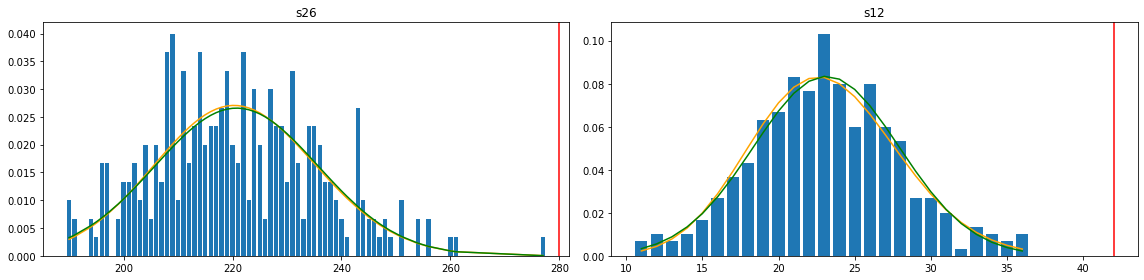

In [36]:
plot_background(shuf_counts[shuf_counts.sense=="+"], real_counts[real_counts.sense=="+"], 
                enr_pos.Matrix_id, genome_len, background='both', figsize=(16,4), ncols=8)

And for the depleted PWMs:

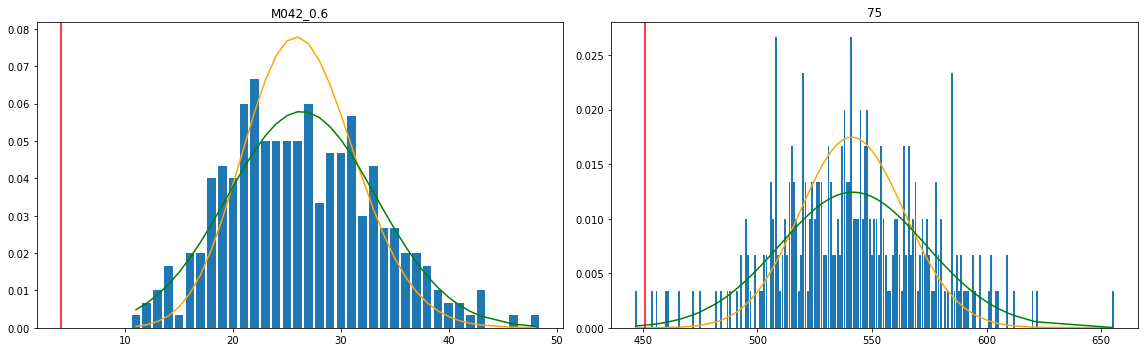

In [37]:
plot_background(shuf_counts[shuf_counts.sense=="+"], real_counts[real_counts.sense=="+"], 
                dep_pos.Matrix_id, genome_len, background='both', figsize=(16,5), ncols=7)

## Enrichment in sliding windows

For any given PWM, we can test for enrichment of its binding sites in sliding windows across the genome using Fisher's exact test. Here we test for enrichment of a specific PWM in the positive ('+') sense genome.

In [38]:
r = enrich_in_sliding_windows(real_sites[real_sites.sense=="+"], genome, '75', 300)
r.head()

,id,start,end,len,count,tot_count,expected,odds,p,padj
0,NC_002204.1,0,300,300,6,451,9.362026,0.633558,0.396032,0.669459
1,NC_002204.1,300,600,300,10,451,9.362026,1.070495,0.738307,0.816851
2,NC_002204.1,600,900,300,11,451,9.362026,1.181619,0.612748,0.758641
3,NC_002204.1,900,1200,300,12,451,9.362026,1.293514,0.399100,0.669459
4,NC_002204.1,1200,1500,300,11,451,9.362026,1.181619,0.612748,0.758641


We select significantly enriched bins:

In [39]:
r[(r.padj<0.05) & (r.odds > 1)]

,id,start,end,len,count,tot_count,expected,odds,p,padj
11,NC_002205.1,900,1200,300,21,451,9.362026,2.336671,0.000732,0.019025
37,NC_002208.1,1800,1841,41,6,451,1.279477,5.321888,0.001676,0.029053


and significantly depleted bins:

In [40]:
r[(r.padj<0.05) & (r.odds < 1)]

,id,start,end,len,count,tot_count,expected,odds,p,padj
50,NC_002211.1,600,900,300,0,451,9.362026,0.0,0.000133,0.006913


## Plot enrichment/depletion  in sliding windows

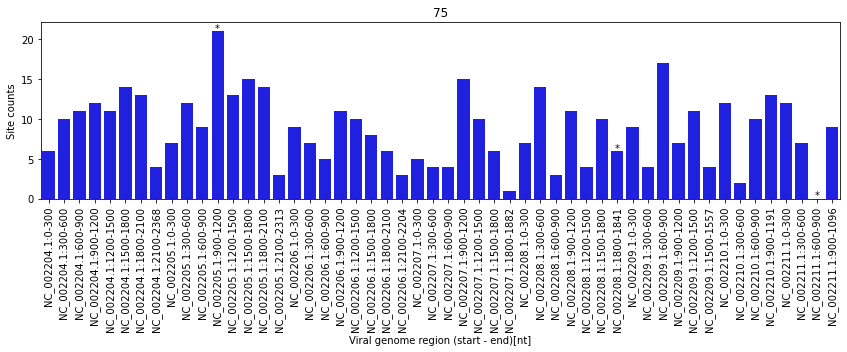

In [41]:
r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start)+'-'+str(row.end), axis=1)
sliding_window_enrichment_plot(sliding_window_df=r, 
                            x_var='window', 
                            y_var='count', 
                            xticklabels='window_name', title='75')